## 1. Importing packages

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from matplotlib import cm
from PIL import Image
from IPython.display import Image

import matplotlib.image as mpimg

from scipy.special import inv_boxcox

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, Normalizer, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from patsy import dmatrices
import statsmodels.api as sm

from scipy.stats import chi2_contingency
import pickle

## 2. Loading data

Defining X (features) and y (target variable) and standardizing column headers before we move on...

In [2]:
df = pd.read_csv("data/creditcardmarketing.csv")

customer_number is important for the predictions, but i won't use it as a feature (unique values)

In [3]:
def clean_headers(df):
    # This function removes spaces replacing them with "_" and lowers all characters
    cols = []
    for c in df.columns:
        c = c.lower().replace(" ", "_").replace("#", "n")
        cols.append(c)
    df.columns = cols

In [4]:
clean_headers(df)

In [5]:
df = df.set_index('customer_number')

## 3. Exploring data

In [6]:
df.shape

(18000, 16)

In [7]:
pd.set_option('display.max_columns', None)
df.head(3)

,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0


### 3.1. Exploring Categoricals

In [8]:
df_cat = df.select_dtypes('object')
df_cat.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
customer_number,,,,,,,
1,No,Air Miles,Letter,High,No,High,No
2,No,Air Miles,Letter,Medium,No,Medium,Yes
3,No,Air Miles,Postcard,High,No,Medium,Yes
4,No,Air Miles,Letter,Medium,No,High,No
5,No,Air Miles,Letter,Medium,No,Medium,Yes


#### 3.1.1. Some numerical columns should be categoricals due to the reduced amount of value types they contain:
- n_bank_accounts_open
- n_credit_cards_held
- n_homes_owned
- household_size

In [9]:
df['n_bank_accounts_open'] = df.n_bank_accounts_open.astype('object')
df['n_credit_cards_held'] = df.n_credit_cards_held.astype('object')
df['n_homes_owned'] = df.n_homes_owned.astype('object')
df['household_size'] = df.household_size.astype('object')

#### 3.1.2. Lets see the number of distinct values each column has and what % of the total values belong to each type.

In [10]:
def cat_exploration(df):
    # This function displays the proportion of each value type for each categorical column and its countplot
    cat = df.select_dtypes('object')
    for c in cat.columns:
        sns.set_style("darkgrid")
        print(c)
        print(cat[c].value_counts(normalize=True).mul(100).round(1))
        fig, axes = plt.subplots(1, 1, figsize=(7, 4))
        sns.countplot(cat[c], color = 'gray')
        plt.show()

offer_accepted
No     94.3
Yes     5.7
Name: offer_accepted, dtype: float64


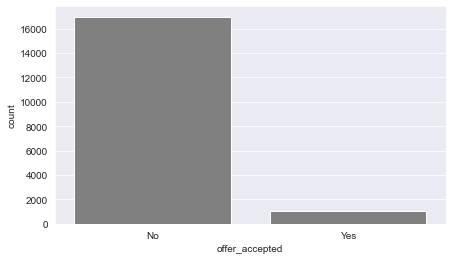

reward
Air Miles    33.7
Cash Back    33.3
Points       33.0
Name: reward, dtype: float64


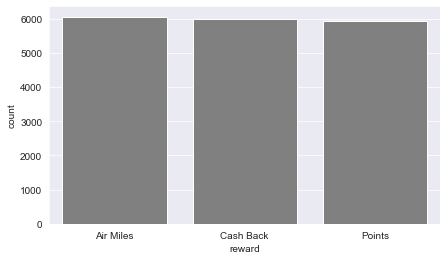

mailer_type
Postcard    50.8
Letter      49.2
Name: mailer_type, dtype: float64


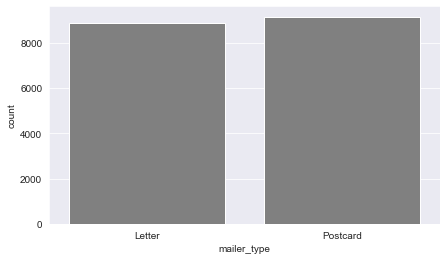

income_level
Medium    50.1
High      25.1
Low       24.8
Name: income_level, dtype: float64


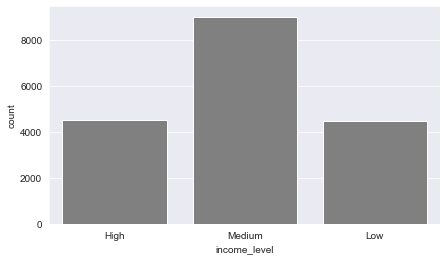

n_bank_accounts_open
1    76.1
2    22.3
3     1.6
Name: n_bank_accounts_open, dtype: float64


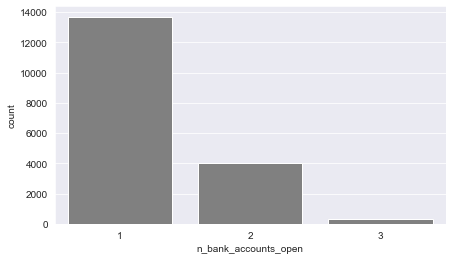

overdraft_protection
No     85.1
Yes    14.9
Name: overdraft_protection, dtype: float64


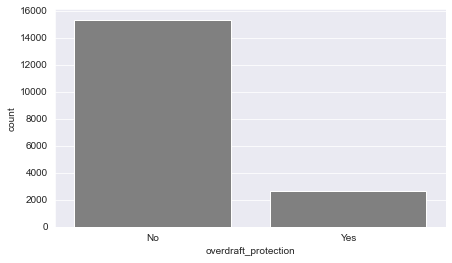

credit_rating
High      33.7
Medium    33.2
Low       33.1
Name: credit_rating, dtype: float64


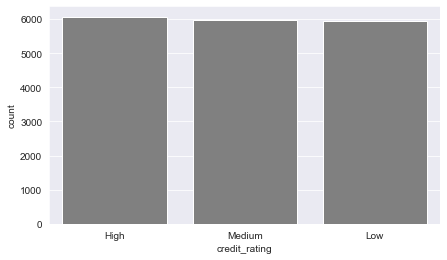

n_credit_cards_held
2    44.1
1    34.2
3    18.8
4     2.9
Name: n_credit_cards_held, dtype: float64


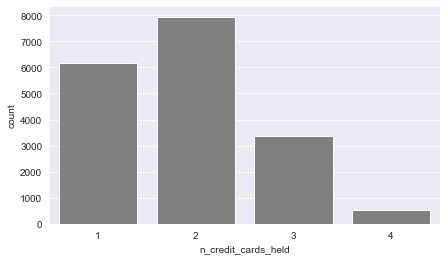

n_homes_owned
1    80.7
2    18.3
3     1.0
Name: n_homes_owned, dtype: float64


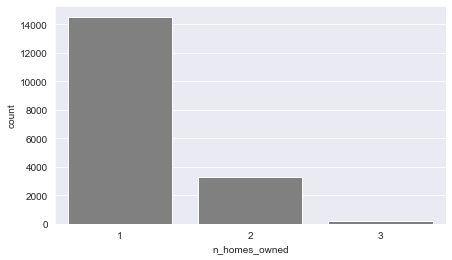

household_size
3    31.7
4    30.8
5    15.8
2    15.6
1     3.0
6     3.0
8     0.0
9     0.0
Name: household_size, dtype: float64


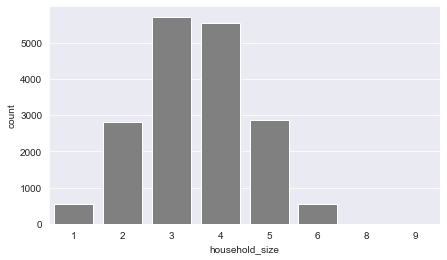

own_your_home
Yes    64.8
No     35.2
Name: own_your_home, dtype: float64


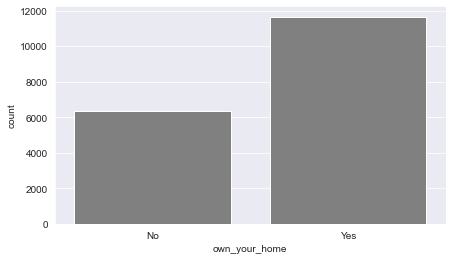

In [11]:
cat_exploration(df)

Takeaways:
- There isn't any categorical column with too many different value types which might require bucketing.
- The largest imbalance occurs with our target variable: "offer_accepted"

### 3.2. Exploring and improving numericals

In [12]:
def num_exploration(df):
    # This column helps us understand how are our numerical columns distributed
    num = df.select_dtypes('number')
    for c in num.columns:
        print(c)
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        sns.set_style("dark")
        # Distribution plot to check normality
        sns.distplot(num[c], ax=axes[0],  color = 'gray')
        # box plot to check outliers
        sns.boxplot(num[c], ax=axes[1],  color = 'gray')
        plt.show()
    # Pair plot to see correlations    
    sns.pairplot(num)
    plt.show()
    # Describe summary table
    return num.describe().apply(lambda x: round(x,2))

average_balance


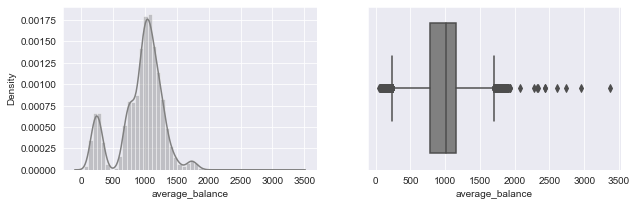

q1_balance


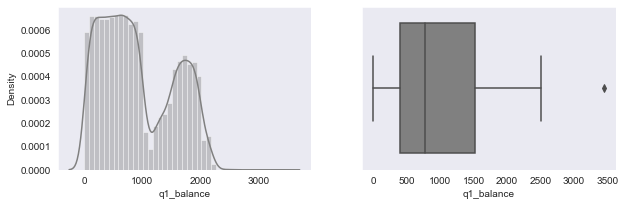

q2_balance


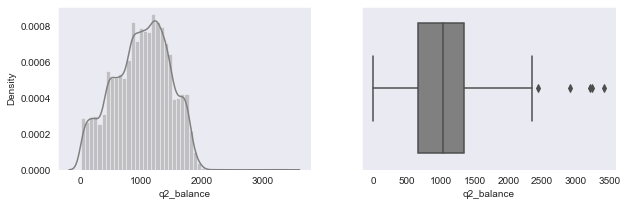

q3_balance


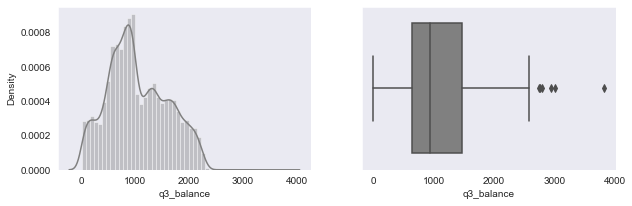

q4_balance


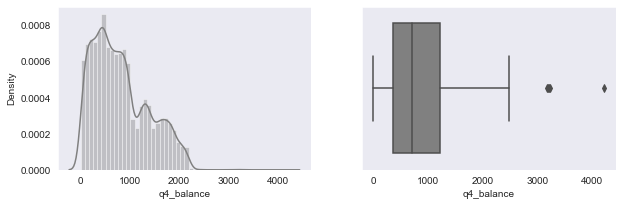

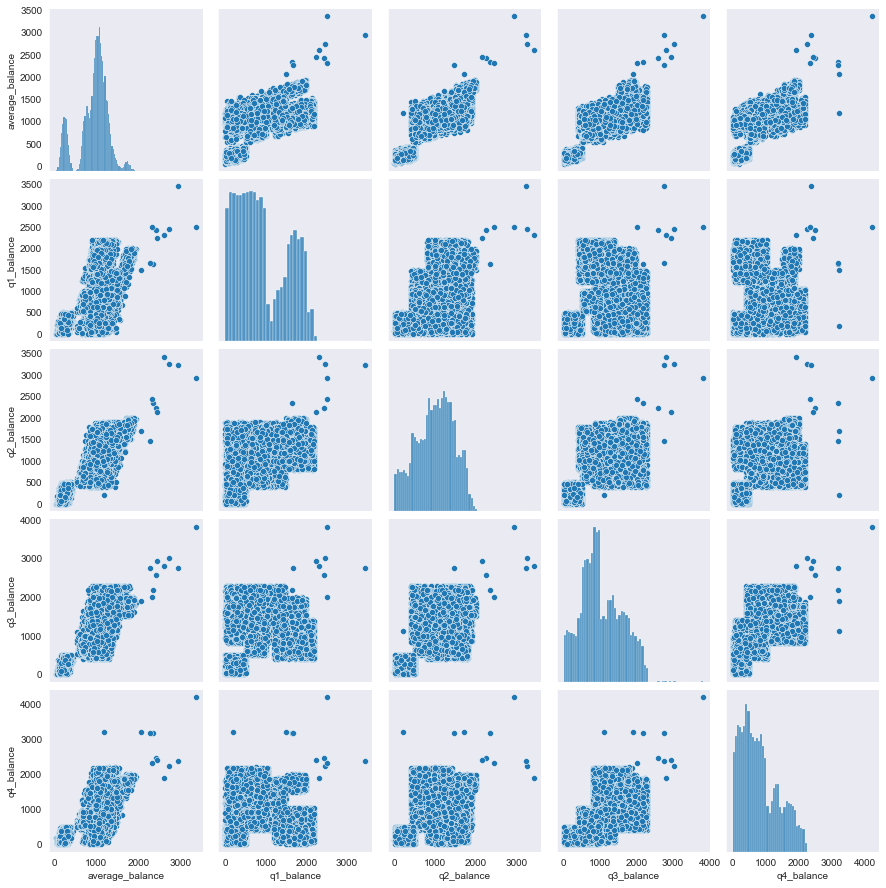

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.00,17976.00,17976.00,17976.00,17976.00
mean,940.52,910.45,999.39,1042.03,810.19
std,350.30,620.08,457.40,553.45,559.00
min,48.25,0.00,0.00,0.00,0.00
25%,787.50,392.75,663.00,633.00,363.00
50%,1007.00,772.00,1032.00,945.50,703.00
75%,1153.25,1521.00,1342.00,1463.00,1212.00
max,3366.25,3450.00,3421.00,3823.00,4215.00


In [13]:
num_exploration(df)

#### 3.2.1. Let's replace nulls

In [14]:
def checking_nulls(df):
    # This function shows which columns have null values and returns a df with only nulls
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            print ("The column ", c, " has ", null_count, " null values")
    nulls = df[df.isna().any(axis=1)]
    return nulls.head(3)

In [15]:
checking_nulls(df)

The column  average_balance  has  24  null values
The column  q1_balance  has  24  null values
The column  q2_balance  has  24  null values
The column  q3_balance  has  24  null values
The column  q4_balance  has  24  null values


,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
324,No,Points,Postcard,Medium,1,No,High,1,1,4,No,NaN,NaN,NaN,NaN,NaN
3071,Yes,Air Miles,Postcard,Low,3,No,Medium,2,1,4,Yes,NaN,NaN,NaN,NaN,NaN
3109,No,Air Miles,Letter,Low,1,No,High,3,1,4,Yes,NaN,NaN,NaN,NaN,NaN


In [16]:
def replace_nulls_mean(df):
    # This function replaces null values with the mean of the column.
    for c in df.columns:
        null_count = df[c].isnull().sum()
        if null_count > 0:
            df[c].fillna((df[c].mean()), inplace=True)
replace_nulls_mean(df)

In [17]:
checking_nulls(df)

,offer_accepted,reward,mailer_type,income_level,n_bank_accounts_open,overdraft_protection,credit_rating,n_credit_cards_held,n_homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,


#### 3.2.2. Let's remove outliers

In [18]:
def remove_outliers(df, threshold=1.5, in_columns=df.select_dtypes(np.number).columns, skip_columns=[]):
    for column in in_columns:
        if column not in skip_columns:
            upper = np.percentile(df[column],75)
            lower = np.percentile(df[column],25)
            iqr = upper - lower
            upper_limit = upper + (threshold * iqr)
            lower_limit = lower - (threshold * iqr)
            df = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    return df

In [19]:
#df1 = df.copy()
#df1 = remove_outliers(df1, threshold=1.5)

#### 3.2.3. And normalize the numerical data

In [20]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

In [21]:
df = remove_outliers(df, threshold=1.5)
df_norm, _ci = boxcox_transform(df)

average_balance


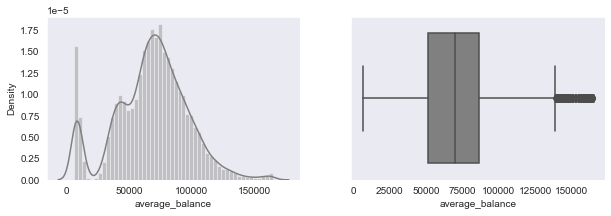

q1_balance


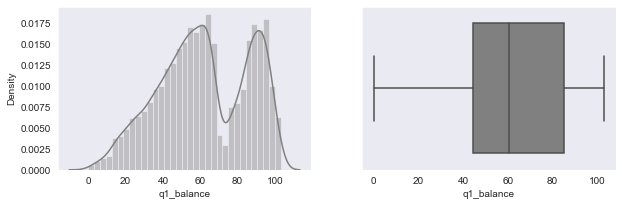

q2_balance


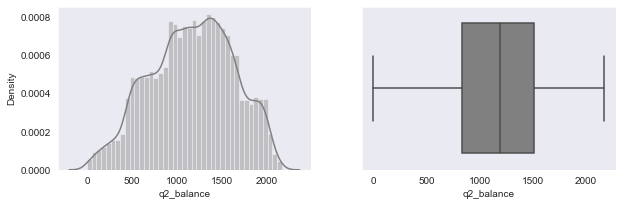

q3_balance


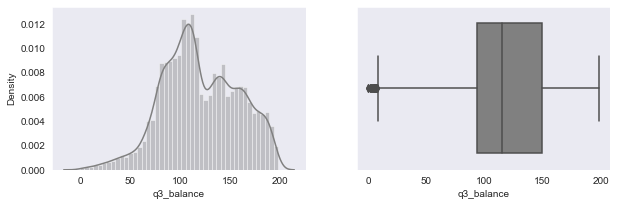

q4_balance


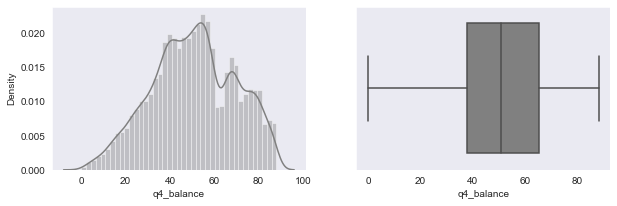

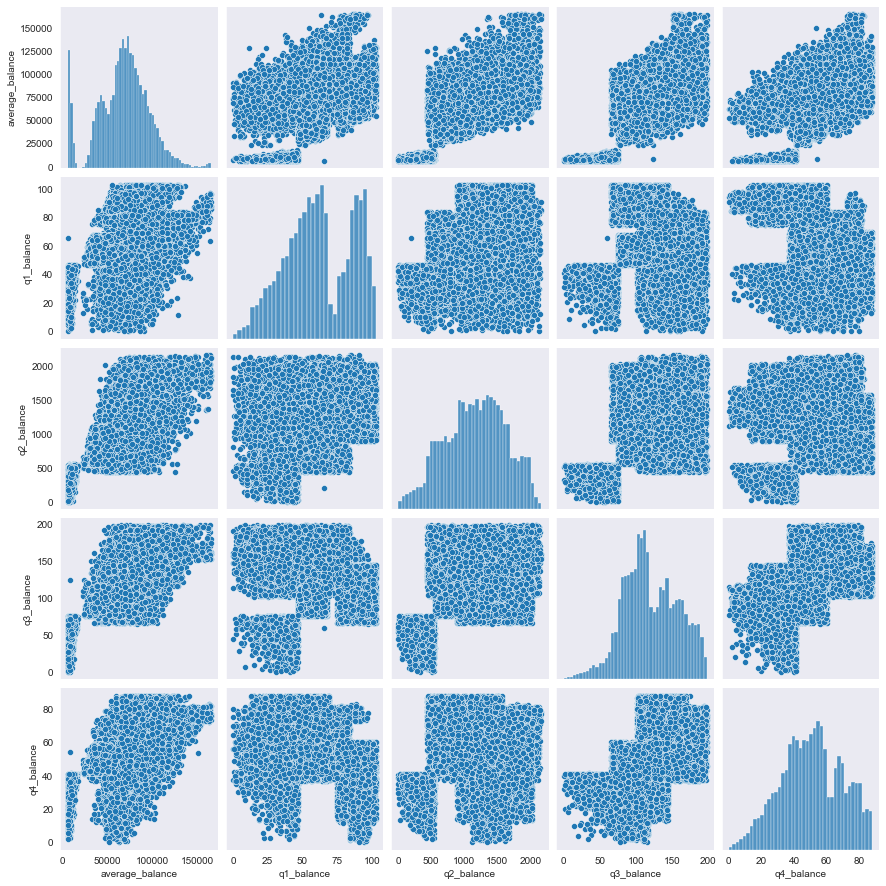

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,16526.00,16526.00,16526.00,16526.00,16526.00
mean,68467.27,61.80,1167.47,120.39,50.60
std,28803.92,24.05,461.56,37.90,18.80
min,6147.62,0.00,0.00,0.00,0.00
25%,51177.44,44.54,835.25,93.47,37.65
50%,69887.71,60.65,1187.11,115.49,50.72
75%,86261.41,85.14,1513.46,149.95,65.43
max,165055.30,103.12,2167.55,198.28,88.01


In [22]:
num_exploration(df_norm)

### 3.3. Check correlations:

We are checking the correlation of the data by also creating modifications of the original one by dropping certain columns that have a lot of correlation. We will later see how do they dirrerently affect the model.

We create the different dfs

In [23]:
# Base dfX
df1 = df.drop('average_balance', axis=1)
# Normalized dfX
df1_norm, _ci = boxcox_transform(df1)

# Base dfX
df2 = df.drop(['q1_balance','q2_balance','q3_balance','q4_balance'], axis=1)
# Normalized dfX
df2_norm, _ci = boxcox_transform(df2)

We define the two correlation matrixes (for df2 it makes no sense to add a correlation matrix as it has only one numerical column: 'average_balance'.

In [24]:
corr_matrix=df.corr(method='pearson')
corr_matrix1=df1.corr(method='pearson')

We plot them:

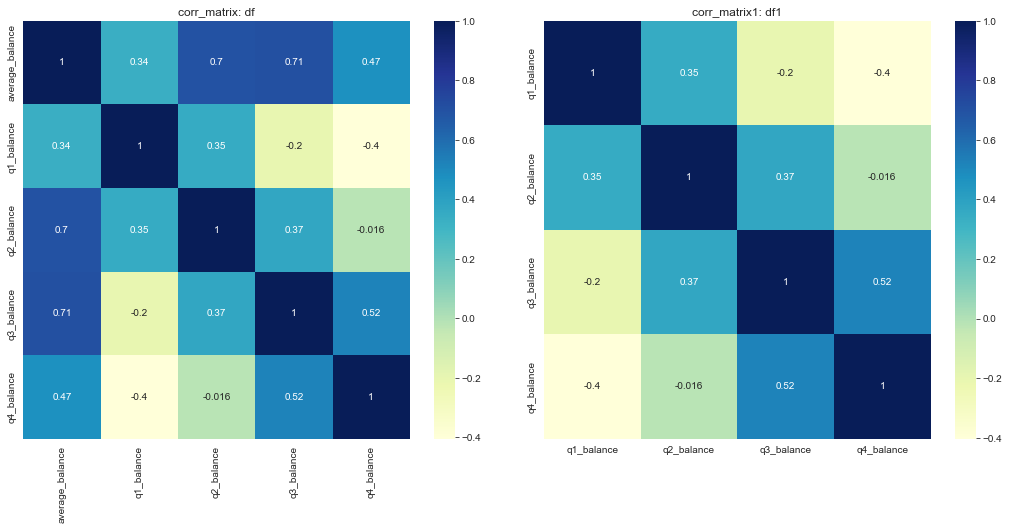

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

sns.heatmap(corr_matrix, ax=ax1, annot=True, cmap="YlGnBu")
sns.heatmap(corr_matrix1, ax=ax2, annot=True, cmap="YlGnBu")

ax1.set_title('corr_matrix: df')
ax2.set_title('corr_matrix1: df1')
fig.tight_layout(pad=3.0)


plt.show()

### 3.4. Multicollinearity analysis

In [26]:
features = "+".join(['reward', 'mailer_type', 'income_level',
       'n_bank_accounts_open', 'overdraft_protection', 'credit_rating',
       'n_credit_cards_held', 'n_homes_owned', 'household_size',
       'own_your_home', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'])

y_enc, X_enc = dmatrices('offer_accepted ~' + features, df, return_type='dataframe')

In [27]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_enc.values, i) for i in range(X_enc.shape[1])]
vif["features"] = X_enc.columns

vif.round(2)

,VIF Factor,features
0,157.41,Intercept
1,1.33,reward[T.Cash Back]
2,1.33,reward[T.Points]
3,1.00,mailer_type[T.Postcard]
4,1.49,income_level[T.Low]
5,1.49,income_level[T.Medium]
6,1.01,n_bank_accounts_open[T.2]
7,1.01,n_bank_accounts_open[T.3]
8,1.00,overdraft_protection[T.Yes]
9,1.33,credit_rating[T.Low]


From the VIF analysis we can extract:
- avearage_balance is the variable with the most multicollinearity, which makes sense as it is composed by the average of the other 4 numerical columns (quarterly balances)

Note: I think that encoding variables prior to the analysis has been an error in regards to studying categorical's multicollinearity. Nevertheless, I've had had to do so because if not I got an error.

### 3.5. Chi Square test

In [28]:
def chi_square_test(df):
    cat = df.select_dtypes('object')    
    cols = cat.columns
    for i in cols:
        for j in cols:
            if i != j:
                data_crosstab = pd.crosstab(df[i], df[j], margins = False)
                chi2_stat, p_val, dof, ex = stats.chi2_contingency(data_crosstab, correction=False)
                print("The chi2_contingency for ", i, " and ", j," is:" )
                print("===Chi2 Stat===")
                print(chi2_stat)
                print("===Degrees of Freedom===")
                print(dof)
                print("===P-Value===")
                print(float(p_val))
                print ("{:.60f}".format(float(p_val)))
                print("===Contingency Table===")
                print(ex)
                print("\n")            

In [29]:
chi_square_test(df)

The chi2_contingency for  offer_accepted  and  reward  is:
===Chi2 Stat===
89.87430113780236
===Degrees of Freedom===
2
===P-Value===
3.04820011738656e-20
0.000000000000000000030482001173865599663931552507340005544552
===Contingency Table===
[[5243.20585744 5199.81120658 5146.98293598]
 [ 314.79414256  312.18879342  309.01706402]]


The chi2_contingency for  offer_accepted  and  mailer_type  is:
===Chi2 Stat===
161.91223760009564
===Degrees of Freedom===
1
===P-Value===
4.323768928840716e-37
0.000000000000000000000000000000000000432376892884071564632470
===Contingency Table===
[[7678.96647707 7911.03352293]
 [ 461.03352293  474.96647707]]


The chi2_contingency for  offer_accepted  and  income_level  is:
===Chi2 Stat===
107.92470279857727
===Degrees of Freedom===
2
===P-Value===
3.668162415938837e-24
0.000000000000000000000003668162415938837221236398797067652848
===Contingency Table===
[[3939.47960789 3874.38763161 7776.1327605 ]
 [ 236.52039211  232.61236839  466.8672395 ]]


The chi2

The chi2_contingency for  mailer_type  and  n_credit_cards_held  is:
===Chi2 Stat===
3.5285945223196458
===Degrees of Freedom===
3
===P-Value===
0.3170724000524377
0.317072400052437697315355080718290992081165313720703125000000
===Contingency Table===
[[2773.09693816 3606.01113397 1528.40493767  232.4869902 ]
 [2856.90306184 3714.98886603 1574.59506233  239.5130098 ]]


The chi2_contingency for  mailer_type  and  n_homes_owned  is:
===Chi2 Stat===
1.2630094885935148
===Degrees of Freedom===
2
===P-Value===
0.5317909891914419
0.531790989191441854089248408854473382234573364257812500000000
===Contingency Table===
[[6572.19048772 1485.0599056    82.74960668]
 [6770.80951228 1529.9400944    85.25039332]]


The chi2_contingency for  mailer_type  and  household_size  is:
===Chi2 Stat===
6.888764895419632
===Degrees of Freedom===
6
===P-Value===
0.33125685620319895
0.331256856203198946086985188230755738914012908935546875000000
===Contingency Table===
[[2.43815805e+02 1.26537940e+03 2.60119448e+

The chi2_contingency for  overdraft_protection  and  n_homes_owned  is:
===Chi2 Stat===
0.10279993490653372
===Degrees of Freedom===
2
===P-Value===
0.9498986659924702
0.949898665992470192520613636588677763938903808593750000000000
===Contingency Table===
[[11359.23193755  2566.74543144   143.02263101]
 [ 1983.76806245   448.25456856    24.97736899]]


The chi2_contingency for  overdraft_protection  and  household_size  is:
===Chi2 Stat===
6.776926367887211
===Degrees of Freedom===
6
===P-Value===
0.3419705968541127
0.341970596854112685036852781195193529129028320312500000000000
===Contingency Table===
[[4.21405966e+02 2.18705440e+03 4.49584830e+03 4.31962399e+03
  2.22876933e+03 4.15446690e+02 8.51325185e-01]
 [7.35940336e+01 3.81945601e+02 7.85151700e+02 7.54376014e+02
  3.89230667e+02 7.25533099e+01 1.48674815e-01]]


The chi2_contingency for  overdraft_protection  and  own_your_home  is:
===Chi2 Stat===
0.953446053559282
===Degrees of Freedom===
1
===P-Value===
0.32884368246857143
0.

The chi2_contingency for  n_homes_owned  and  overdraft_protection  is:
===Chi2 Stat===
0.10279993490653372
===Degrees of Freedom===
2
===P-Value===
0.9498986659924702
0.949898665992470192520613636588677763938903808593750000000000
===Contingency Table===
[[11359.23193755  1983.76806245]
 [ 2566.74543144   448.25456856]
 [  143.02263101    24.97736899]]


The chi2_contingency for  n_homes_owned  and  credit_rating  is:
===Chi2 Stat===
3.2589401041088073
===Degrees of Freedom===
4
===P-Value===
0.5154640442198246
0.515464044219824613080049857671838253736495971679687500000000
===Contingency Table===
[[4487.49812417 4432.59530437 4422.90657146]
 [1014.00036306 1001.59445722  999.40517972]
 [  56.50151277   55.81023841   55.68824882]]


The chi2_contingency for  n_homes_owned  and  n_credit_cards_held  is:
===Chi2 Stat===
2.7522246690741063
===Degrees of Freedom===
6
===P-Value===
0.8392405415002474
0.839240541500247405615198204031912609934806823730468750000000
===Contingency Table===
[[4.5

## 4. Building models

### 4.1. Defining functions so we can easily work on improving the model by tweaking things:

#### This function will return the basic results of a LogisticRegression model:

In [30]:
def logreg_model(X_train, X_test, y_train, y_test):
    # This function will return the basic results of a LogisticRegression model:
    
    # Fitting the model
    logreg = LogisticRegression()
    logreg.fit(X_train_sm, y_train_sm)
    
    # Calculating the accuracy score
    score = logreg.score(X_test, y_test)
    
    # Making predictions
    y_pred = logreg.predict(X_test)
    values_predicted = pd.Series(y_pred).value_counts()
    
    # Building the confusion matrix with the predicted values
    cf_matrix = confusion_matrix(y_test, y_pred)

    # Printing the score, the predicted values and the cm
    print("Score: ",score,'\n')
    print("Value counts:",'\n', values_predicted)
    print('\n', cf_matrix)

#### This function will return the following information for a LogisticRegression model:
* A confusion matrix
* ROC Curves
* Classification report

It is an evolution of the previous function.

In [31]:
def model_results(X_train, X_test, y_train, y_test):
    # Fitting the model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # Calculating the accuracy score
    score = logreg.score(X_test, y_test)
    
    # Making predictions
    y_pred = logreg.predict(X_test)
    values_predicted = pd.Series(y_pred).value_counts()
    
    # Building the confusion matrix with the predicted values
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plotting confusion matrix
    plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues')
    plt.show()
    print("Value counts:",'\n', values_predicted)
    print('\n',cm)
    
    
    # Plotting ROC curves
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

    # Printing classification report
    class_report = classification_report(y_test, y_pred)
    print('Classification report:', '\n')
    print(class_report)

#### This function will calculate the confusion matrix of a LogisticRegression model given the X-y Train-test split data

In [32]:
def sensitivity(X_train, X_test, y_train, y_test):
    # This function will calculate the confusion matrix of a LogisticRegression model given the X-y Train-test split data
    
    # Fitting the model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    
    # Calculating the accuracy score
    score = logreg.score(X_test, y_test)
    
    # Making predictions
    y_pred = logreg.predict(X_test)
    values_predicted = pd.Series(y_pred).value_counts()
    
    # Building the confusion matrix with the predicted values
    cf_matrix = confusion_matrix(y_test, y_pred)
 
    #True positives
    TP = cf_matrix[1][1]
    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    FN = cf_matrix[1][0]
    
    # Calculating sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    
    # Printing results
    print('\n',"Sensitivity is: ", round(conf_sensitivity,5))

In [33]:
def sensitivity_and_matrix(X_train, X_test, y_train, y_test):
    # This funcction will take the split of a df and return the specificity, sensitivity and accuracy of the applied LogReg model.
    
    # Fitting the model
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)

    # Calculating the accuracy score
    score = logreg.score(X_test, y_test)

    # Making predictions
    y_pred = logreg.predict(X_test)
    values_predicted = pd.Series(y_pred).value_counts()
    
    # Building the confusion matrix with the predicted values
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print confusion matrix
    plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues')
    plt.show()
 
    # True positives
    TP = cf_matrix[1][1]
    TN = cf_matrix[0][0]
    FP = cf_matrix[0][1]
    FN = cf_matrix[1][0]
    
    # Calculating sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    
    # Calculating specificity
    conf_specificity = (TN / float(FP + TN))
    
    # Printing scores
    print('\n',"Sensitivity is: ", round(conf_sensitivity,5),
          '\n',"Specificity is: ", round(conf_specificity,5),
         '\n',"Accuracy is: ", round(score,5))

#### This function will take a df and the target column and return its sensitivity after:
* Splitting data (X-y) (Train-test)
* Encoding categoricals
* Balancing with SMOTE
* applying a LogisticRegression model


In [34]:
def sens_test_smote(df, column_to_drop):
    # This function will take a df and return the Sensitivity, specificity and accuracy after applying a LogReg model.
    
    #X-y split
    X_model = df.drop(column_to_drop, axis=1)
    y_model = df[column_to_drop]
    
    # Encoding categoricals
    X_model = pd.get_dummies(X_model, drop_first=True)
    y_model = pd.get_dummies(y_model, drop_first=True)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, random_state=0)

    #Balancing data with SMOTE    
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Printing scores
    return sensitivity_and_matrix(X_train, X_test, y_train, y_test)

### 4.2. Testing sensitivity for different model configurations

#### df: has the following numerical columns: [q1_balance, q2_balance, q3_balance, q4_balance, average_balance]

- data: df, balance technique: SMOTE, normalized = true

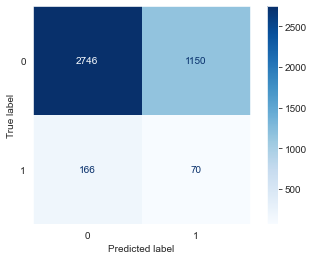


 Sensitivity is:  0.29661 
 Specificity is:  0.70483 
 Accuracy is:  0.68151


In [35]:
sens_test_smote(df_norm, column_to_drop='offer_accepted')

- data: df, balance technique: SMOTE, normalized = false

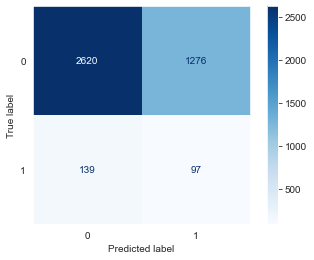


 Sensitivity is:  0.41102 
 Specificity is:  0.67248 
 Accuracy is:  0.65755


In [36]:
sens_test_smote(df, column_to_drop='offer_accepted')

#### df1: has the following numerical columns: [q1_balance, q2_balance, q3_balance, q4_balance]

- data: d1, balance technique: SMOTE, normalized = true

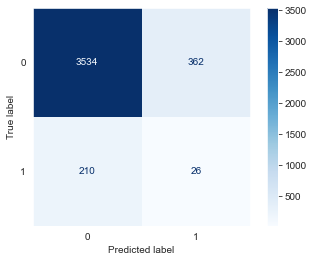


 Sensitivity is:  0.11017 
 Specificity is:  0.90708 
 Accuracy is:  0.86157


In [37]:
sens_test_smote(df1_norm, column_to_drop='offer_accepted')

- data: d1, balance technique: SMOTE, normalized = false

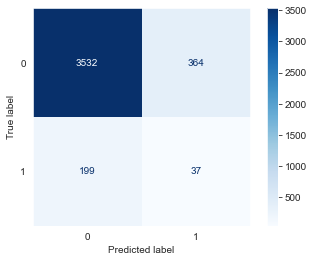


 Sensitivity is:  0.15678 
 Specificity is:  0.90657 
 Accuracy is:  0.86375


In [38]:
sens_test_smote(df1, column_to_drop='offer_accepted')

#### df2:  has the following numerical columns: [average_balance]

- data: d2, balance technique: SMOTE, normalized = true

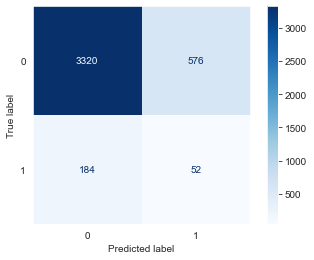


 Sensitivity is:  0.22034 
 Specificity is:  0.85216 
 Accuracy is:  0.81607


In [39]:
sens_test_smote(df2_norm, column_to_drop='offer_accepted')

- data: d2, balance technique: SMOTE, normalized = false

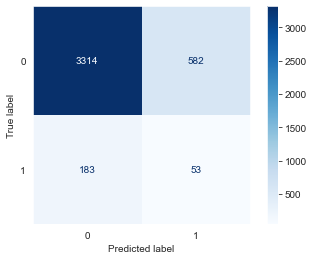


 Sensitivity is:  0.22458 
 Specificity is:  0.85062 
 Accuracy is:  0.81486


In [40]:
sens_test_smote(df2, column_to_drop='offer_accepted')

## 5. Conclusions

The best model for this business case is the one that has a better sensitivity score withou sacrificing too much specificity. 

We have been able to see that the df variation that performed better is the one that works with the original df normalized. 

Nevertheless, the results are volatile given that in each run, SMOTE provokes different results in the different metrics we are using to evaluate each model.

## 6. Tableau visualizations

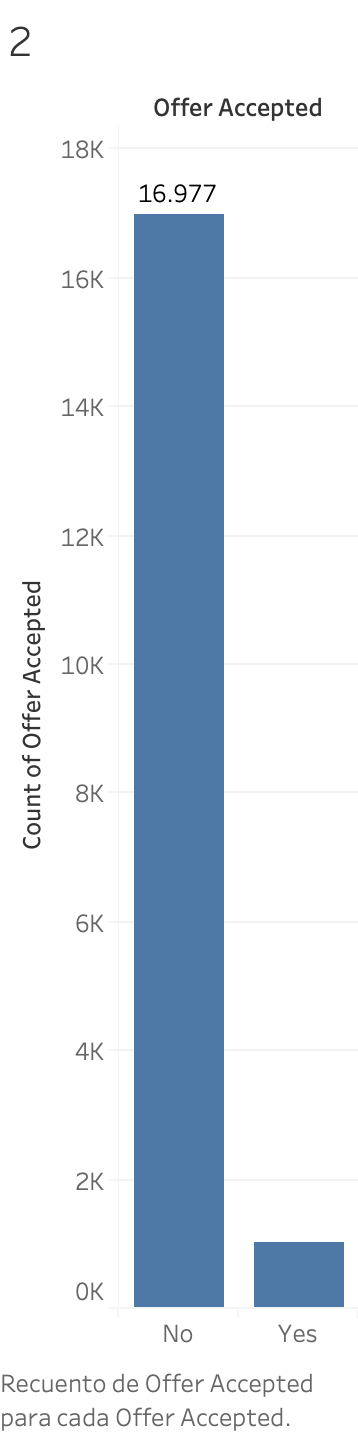

In [41]:
ex_2 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/2.png')
ex_2

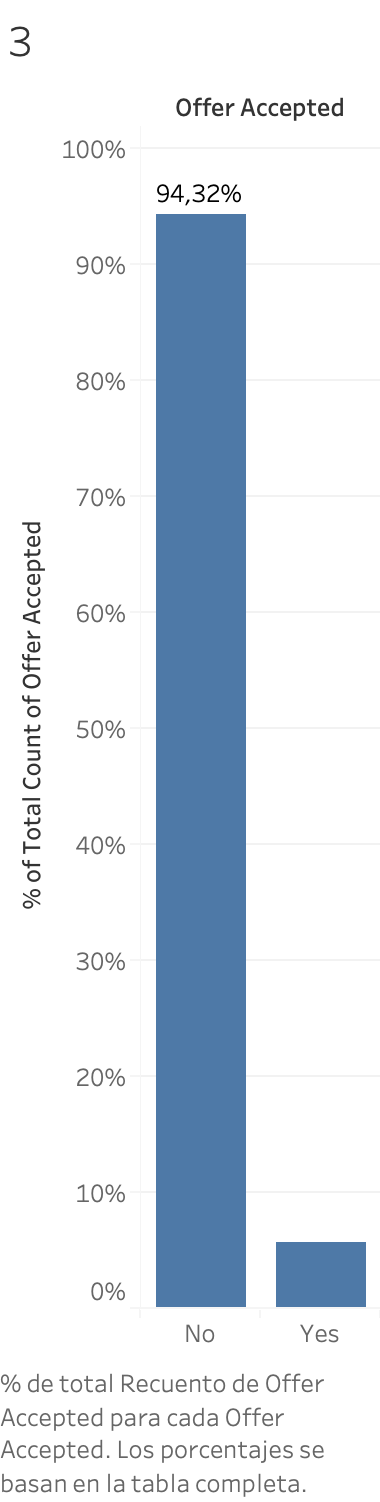

In [42]:
ex_3 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/3.png')
ex_3

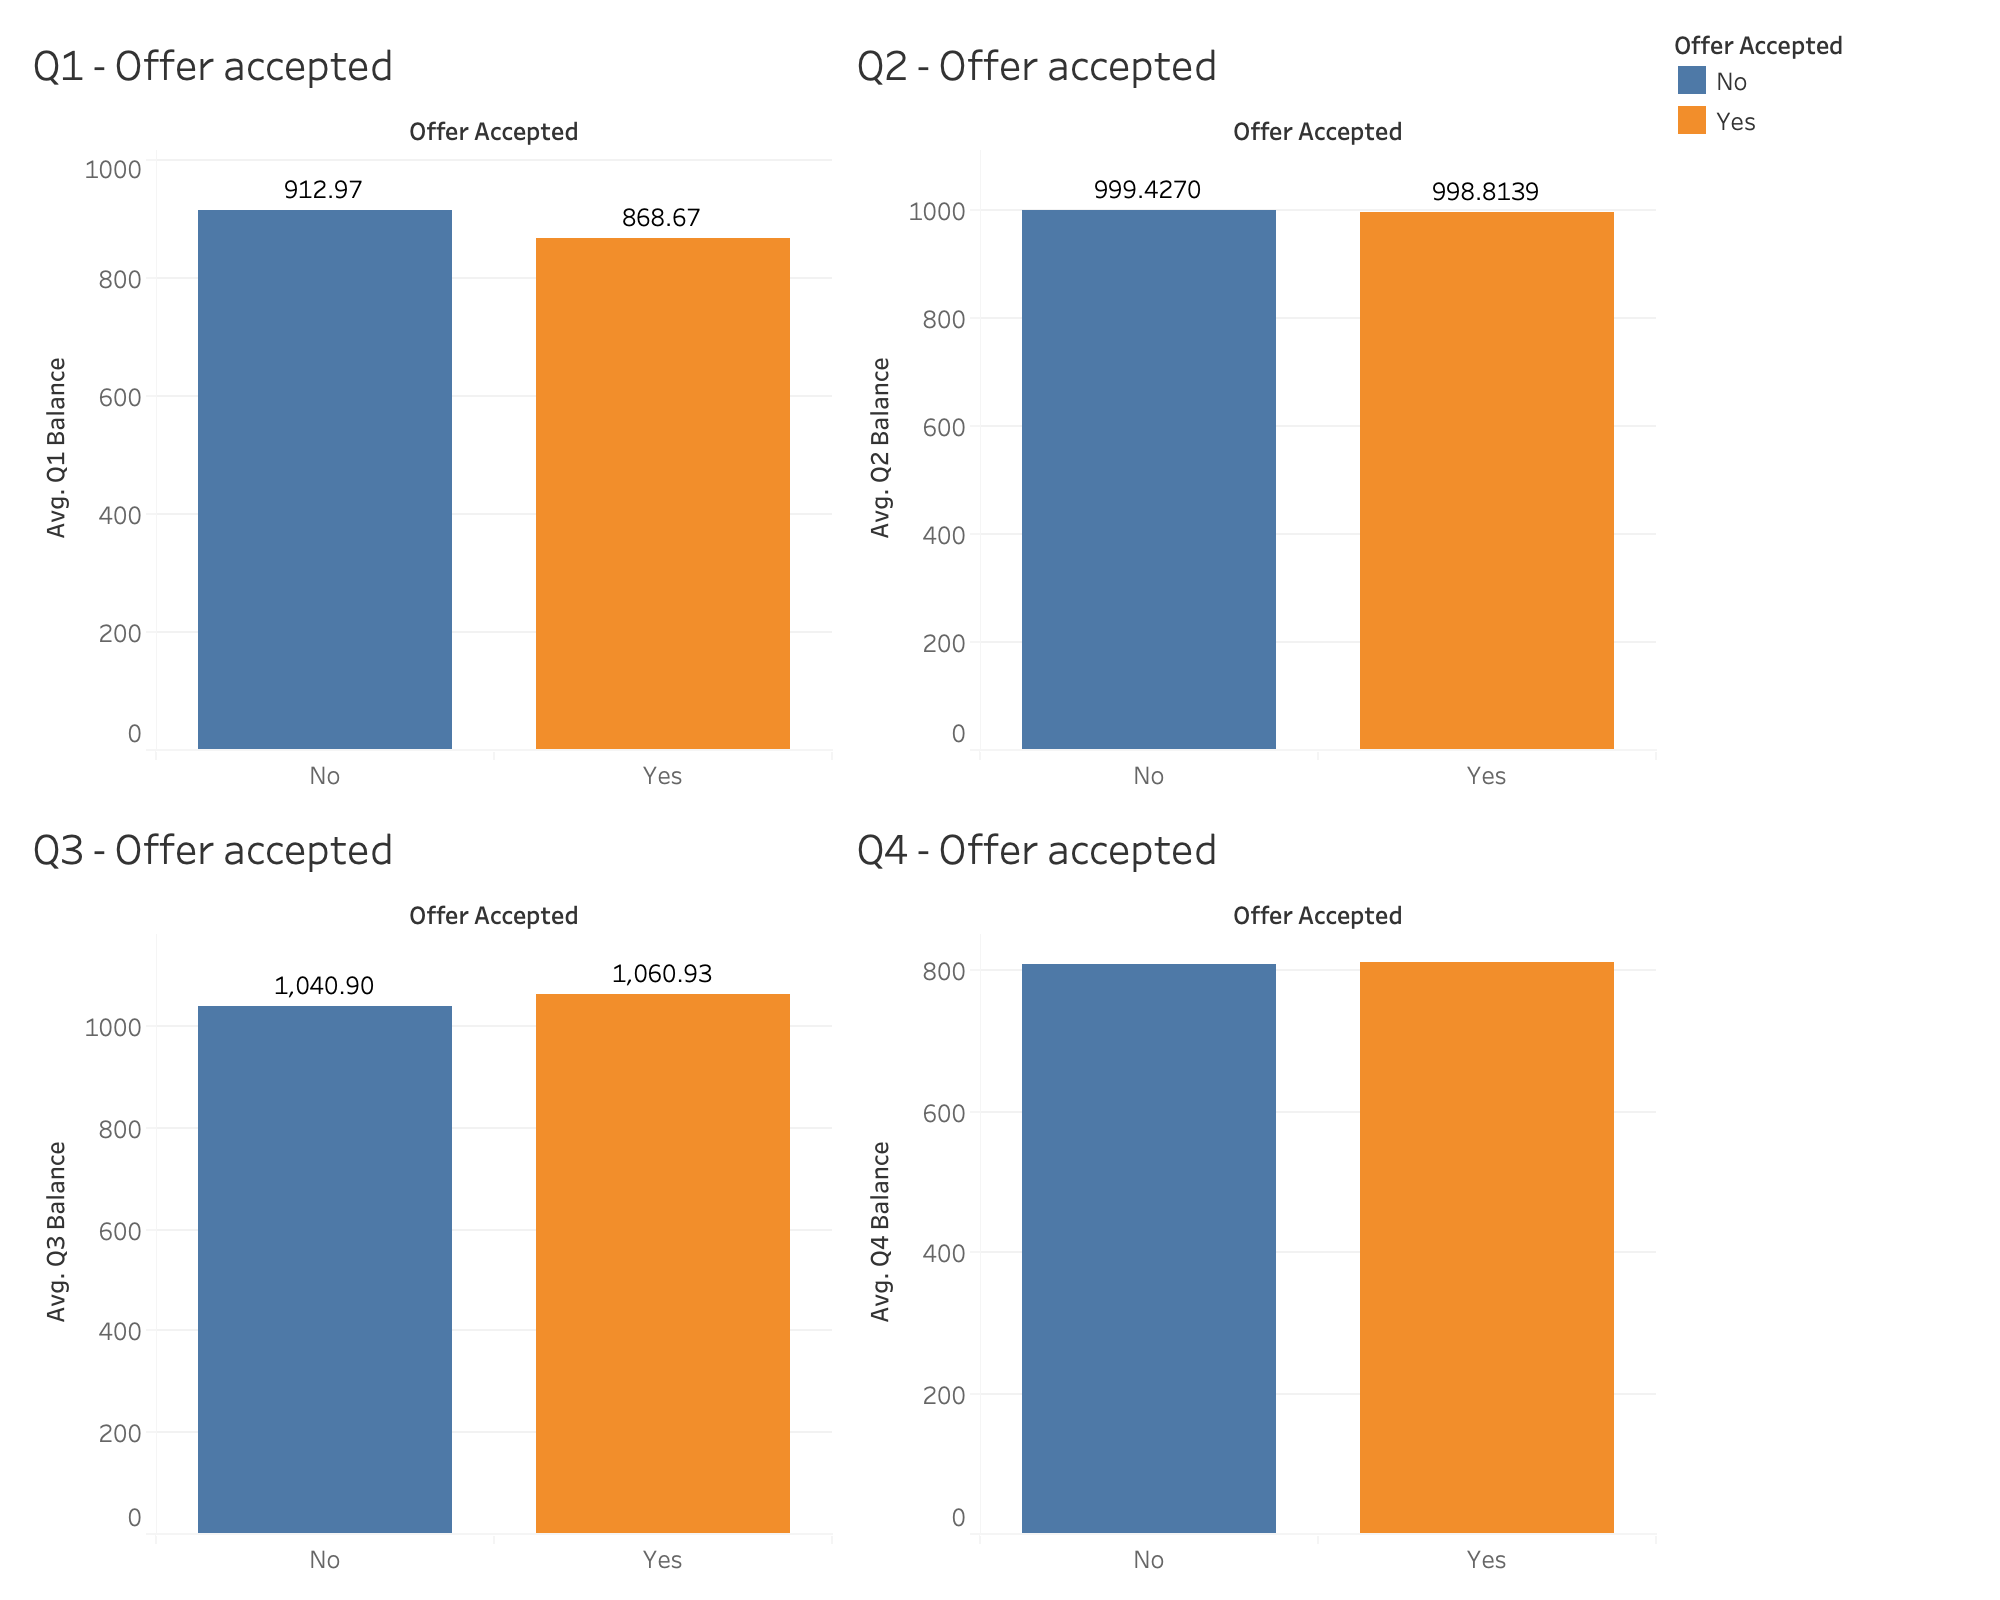

In [43]:
ex_4 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/4.png')
ex_4

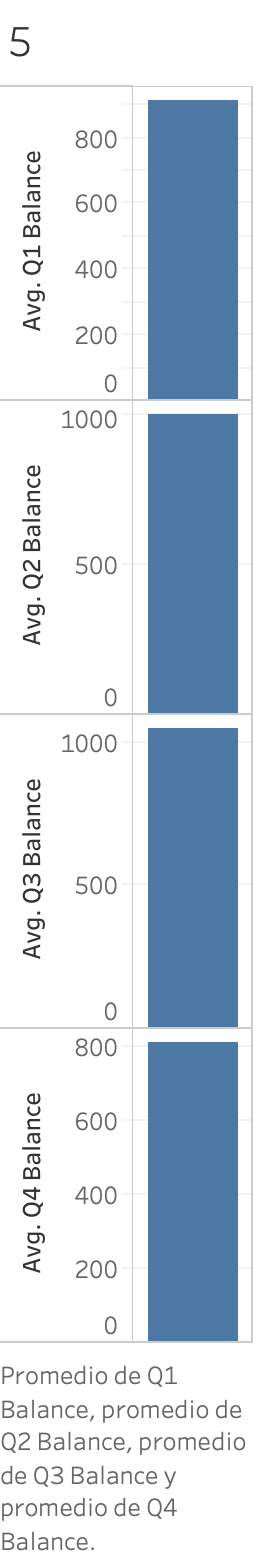

In [44]:
ex_5 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/5.png')
ex_5

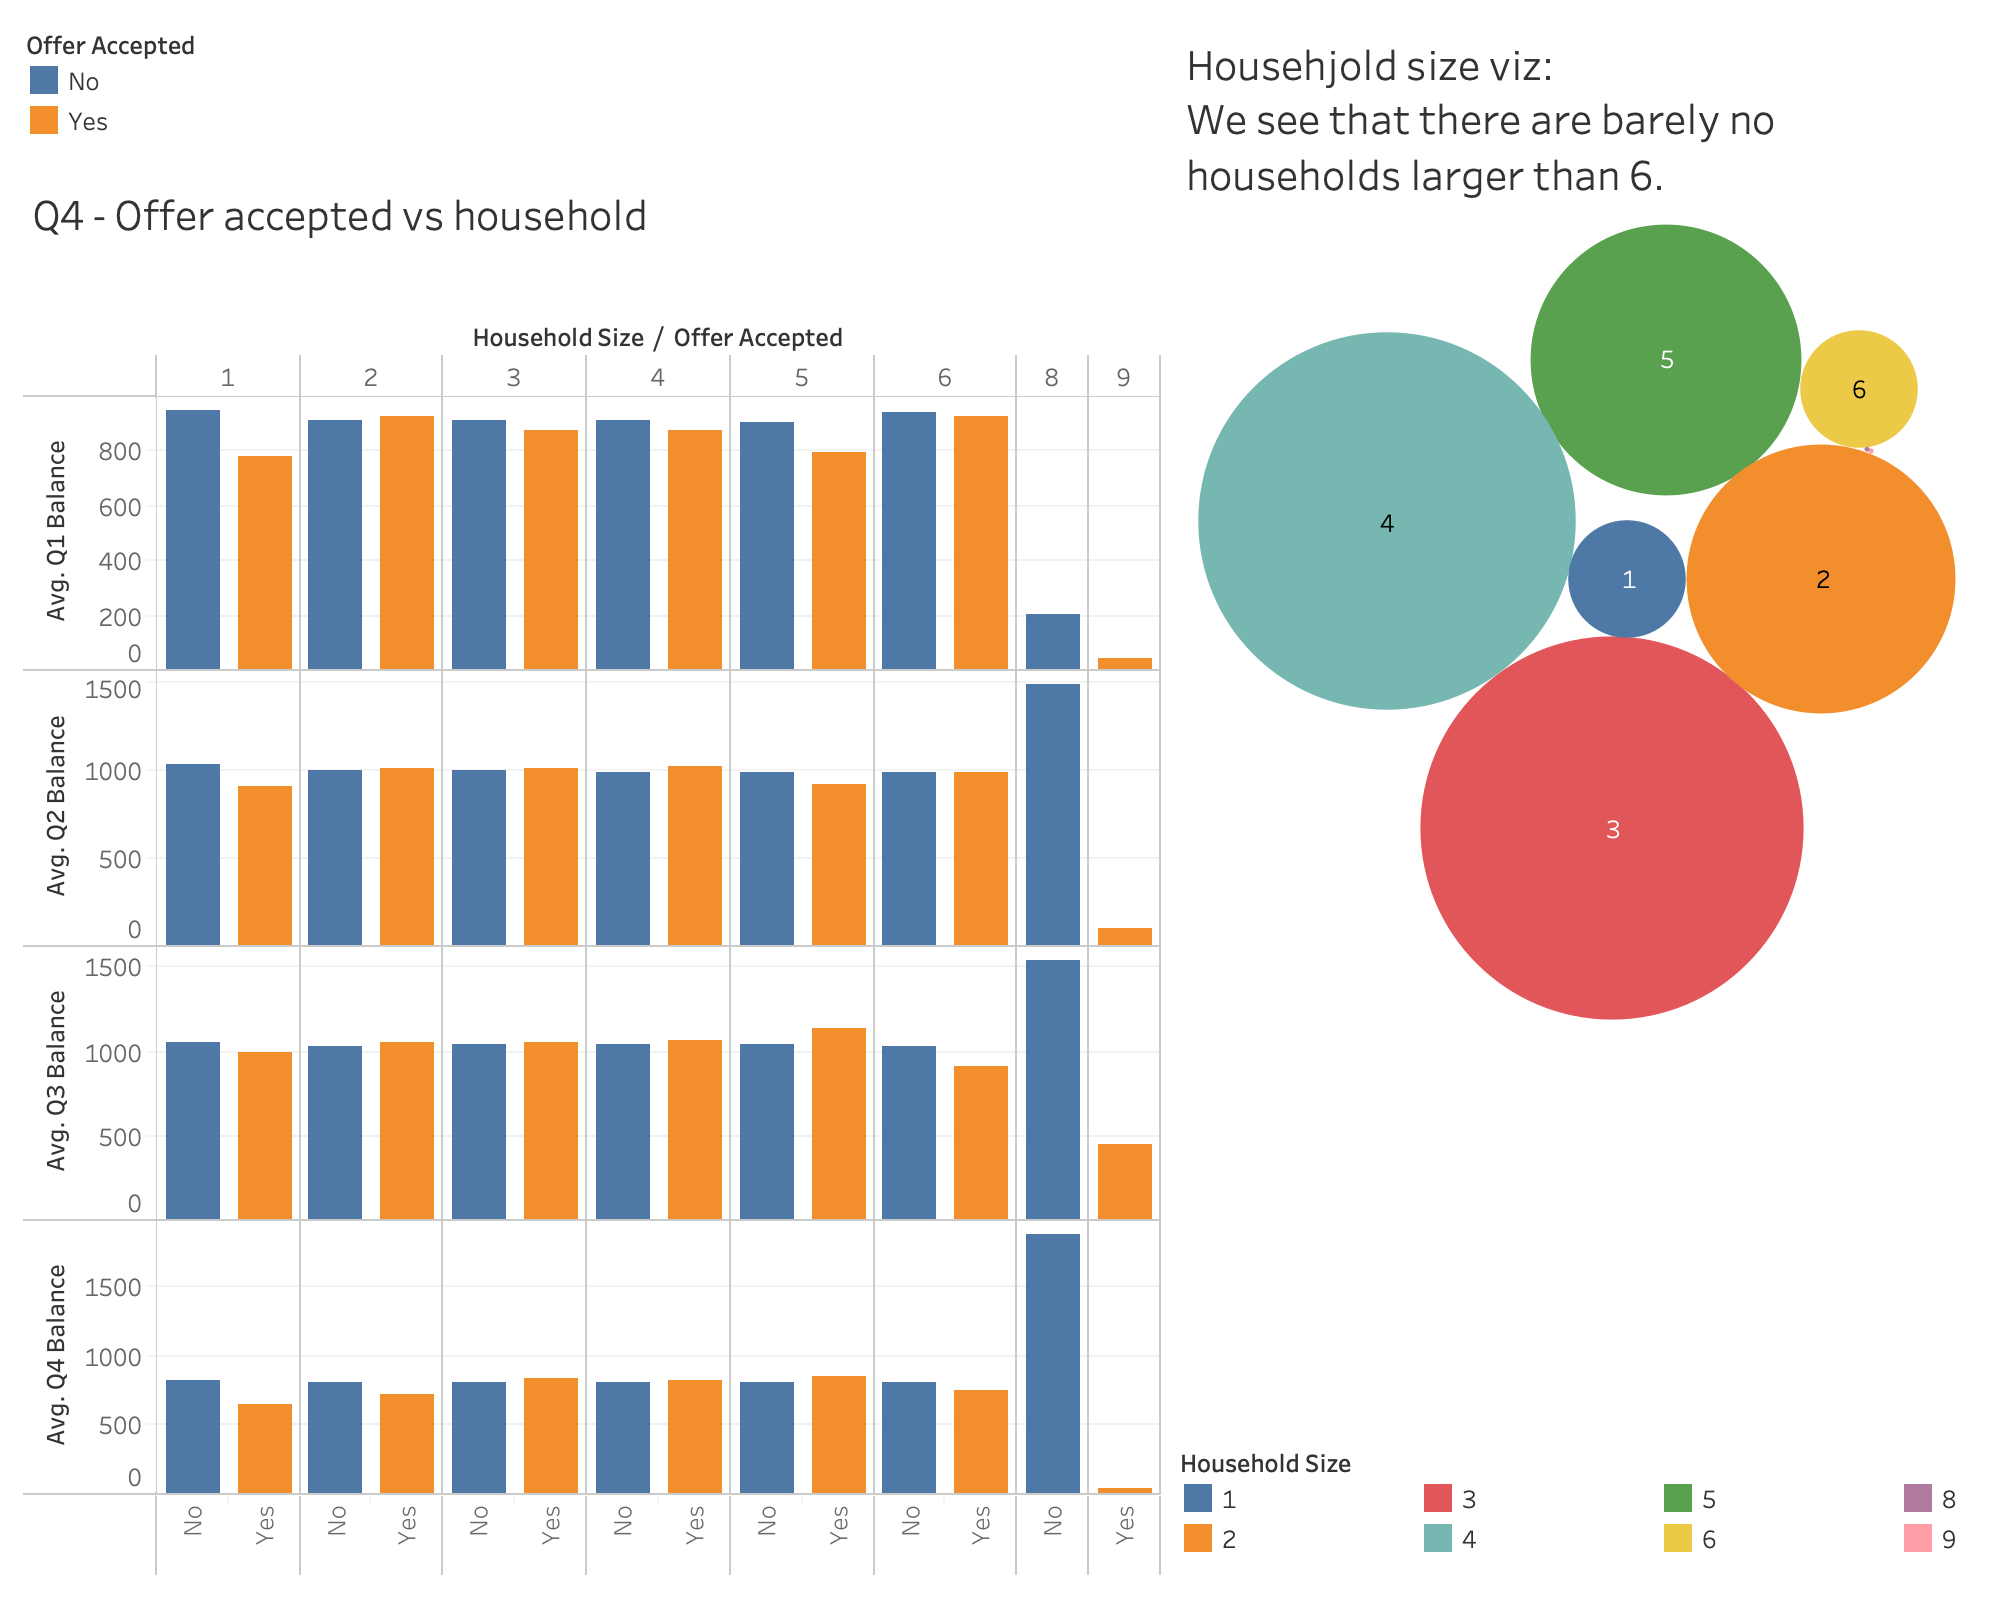

In [45]:
ex_6 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/6.png')
ex_6

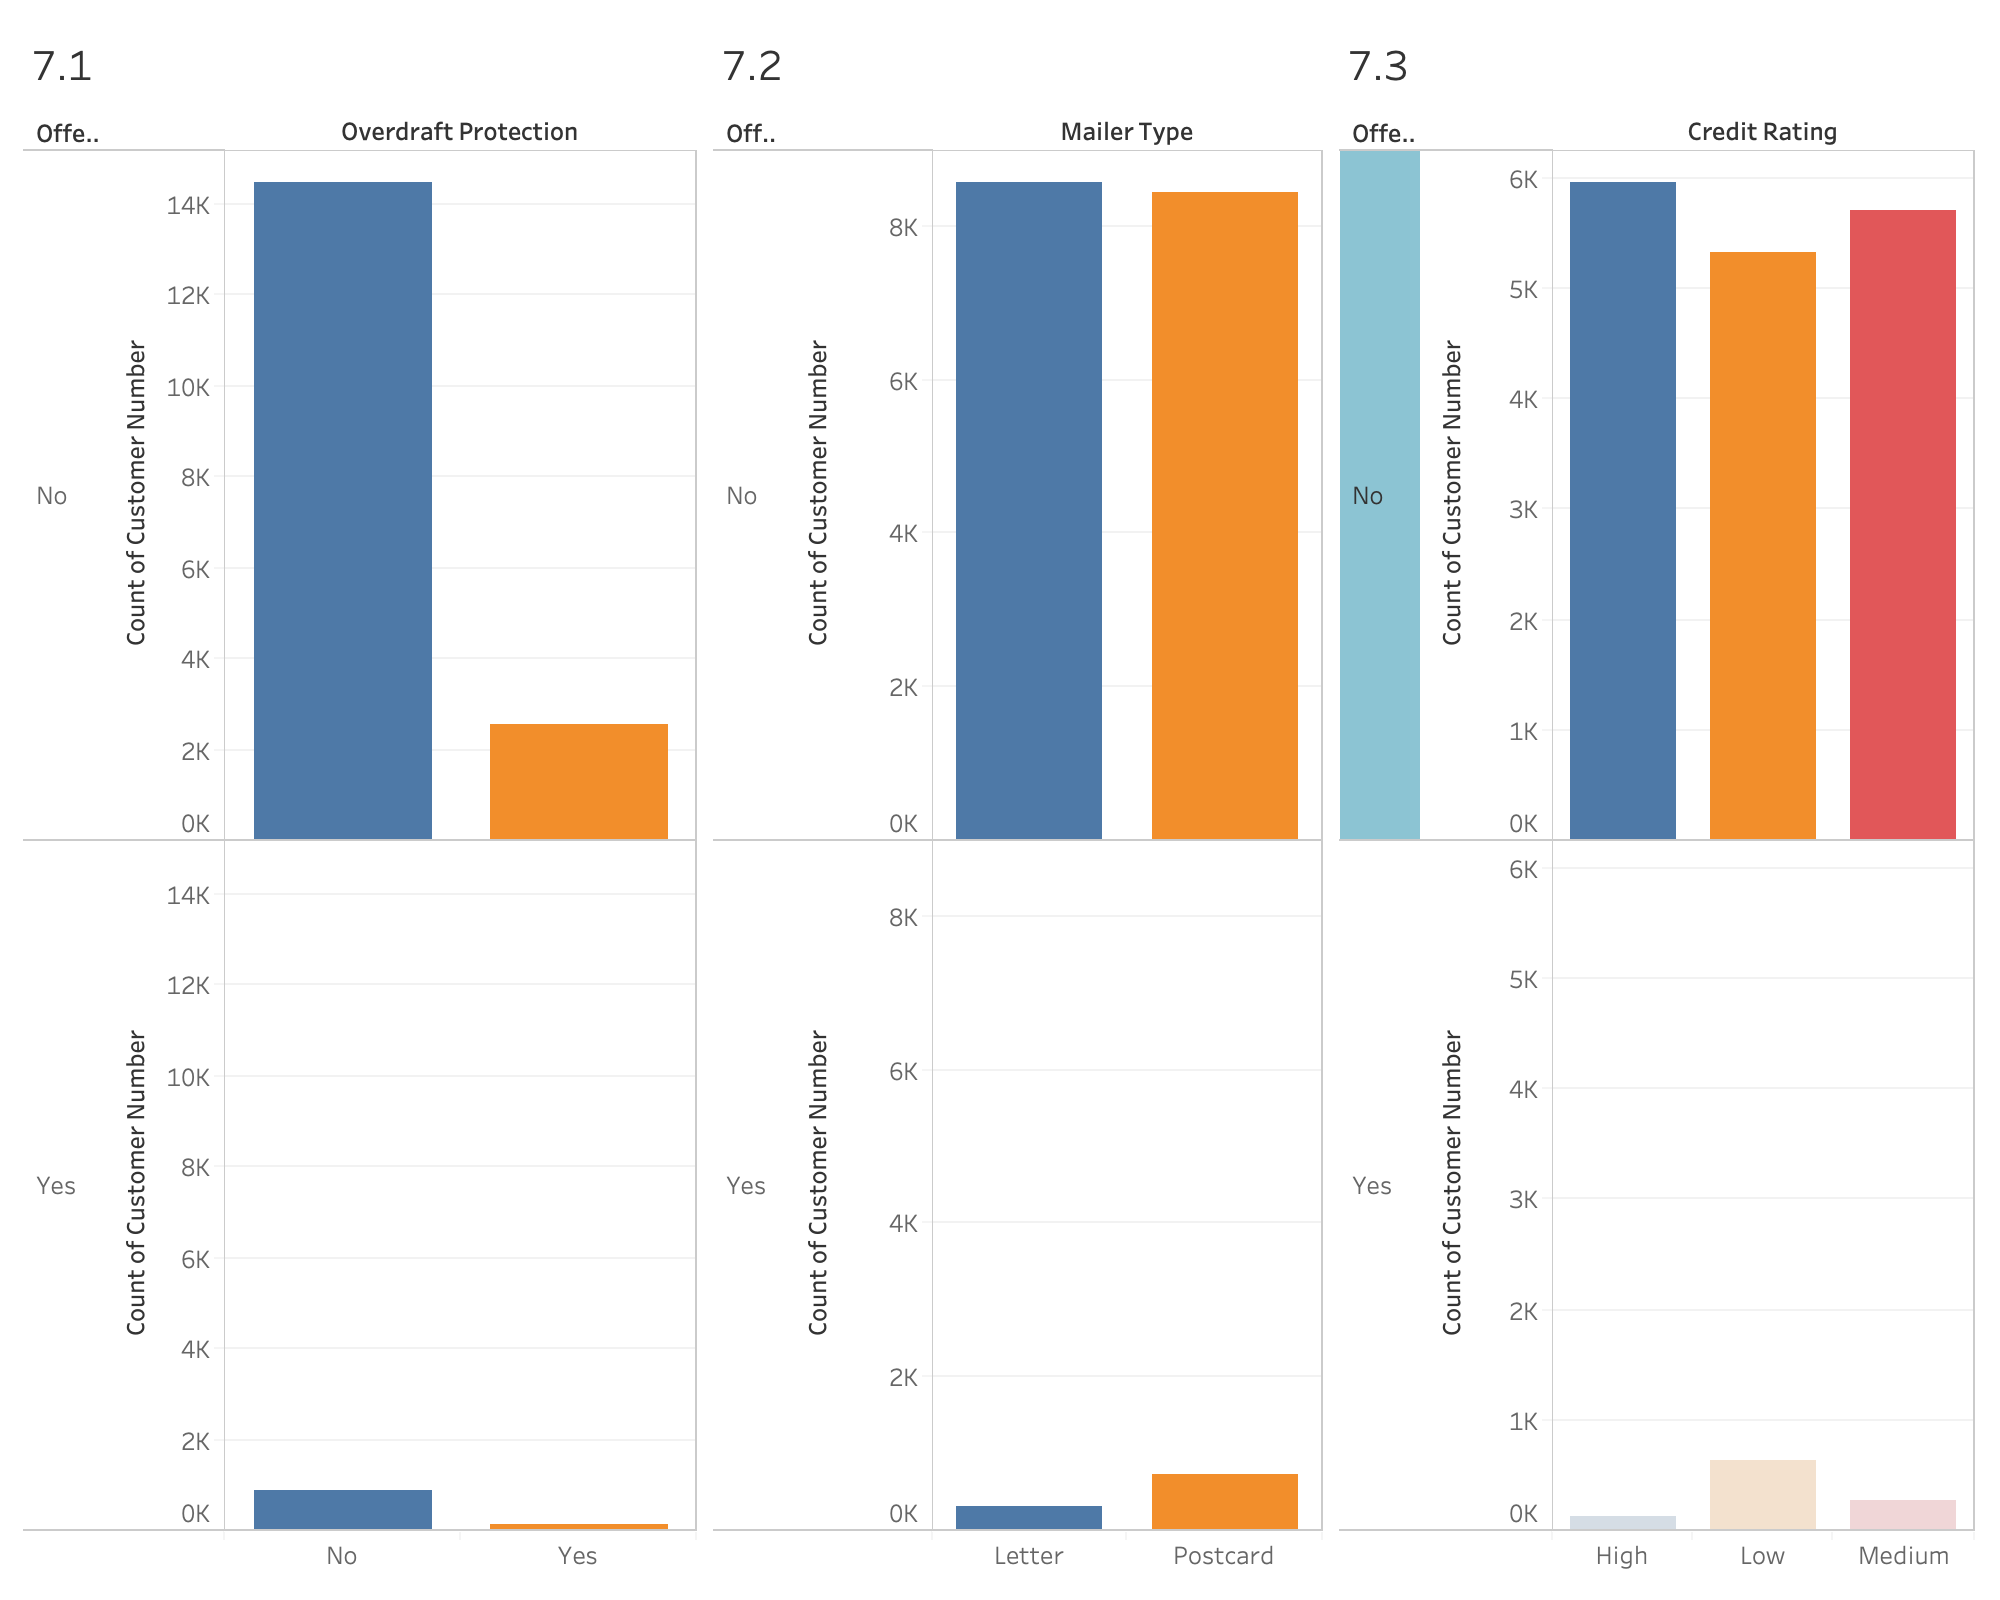

In [46]:
ex_7 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/7.png')
ex_7

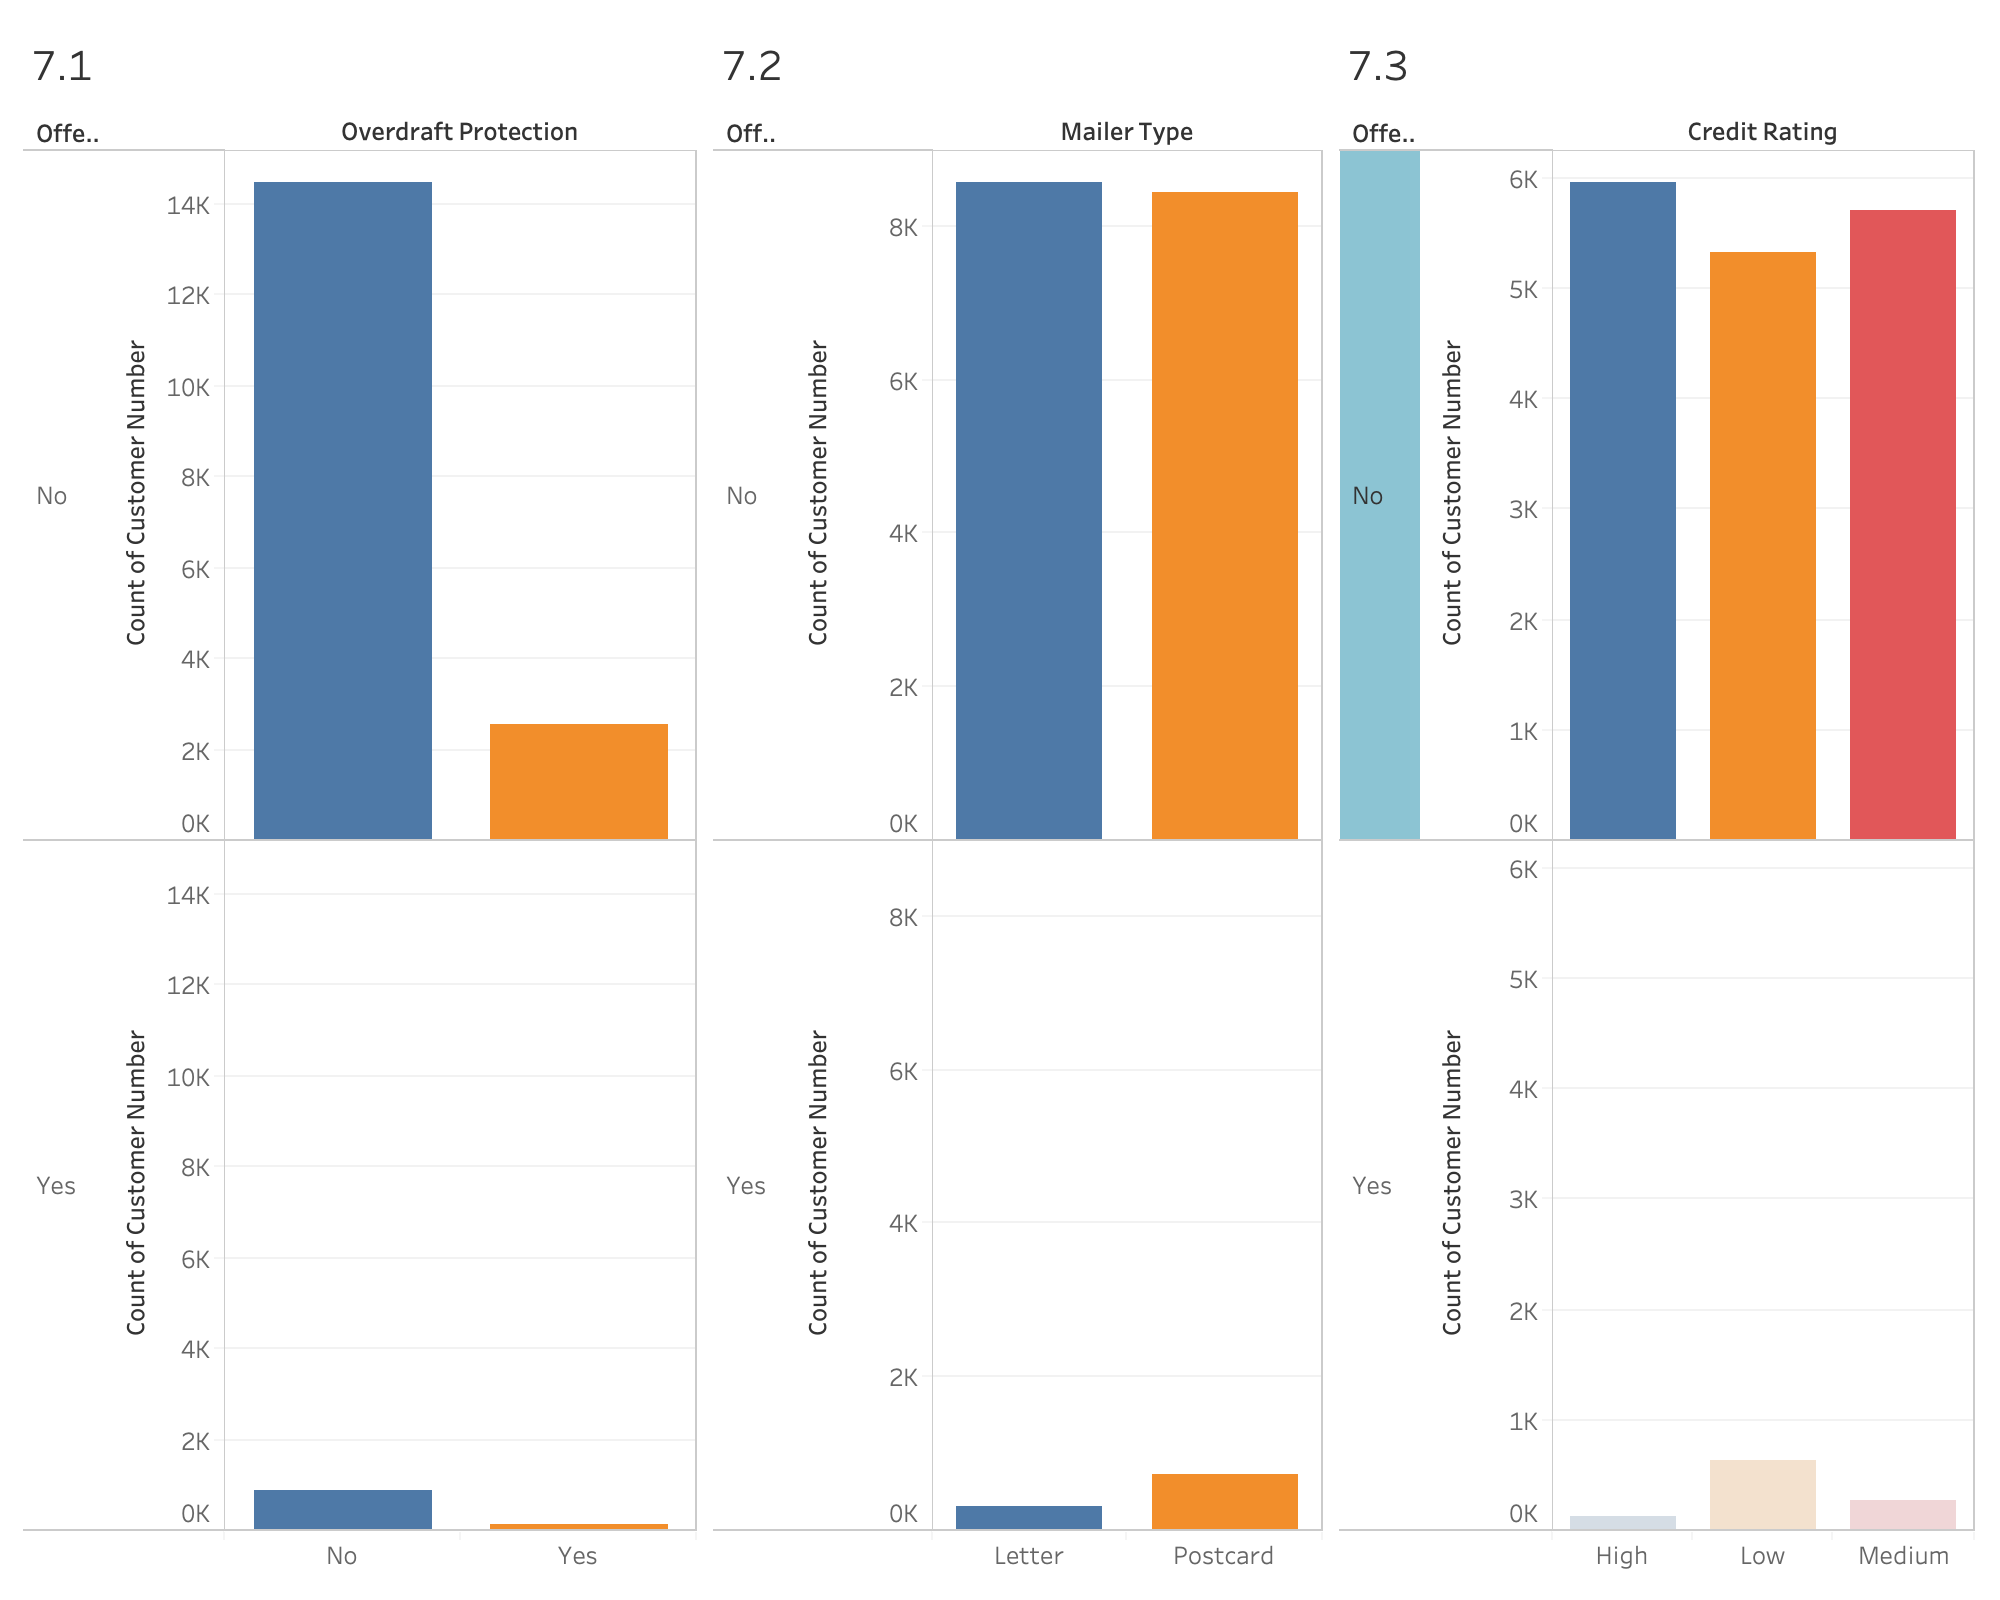

In [47]:
ex_8 = Image(filename='/Users/ignaciolorenzoqueralt/Documents/Ironhack/projects/mid-bootcamp-project/classification/tableau/7.png')
ex_8